In [1]:
# Section 1: Read in Packages

import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Section 2: Read in data - this step can stay the same

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = round(add_avg['Avg_Score'] - add_avg['Round_total'],2)

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2019-11-03"]
test_data = mydata_all[mydata_all['date_round'] > "2019-11-03"]


# Filter by player
power_train = train_data[train_data['player'] == "Seamus Power"]
power_test = test_data[test_data['player'] == "Seamus Power"]

# Order by date round in both train and test
power_train = power_train.sort_values(by='date_round')
power_test = power_test.sort_values(by='date_round')

# Create a time series object
train_series = pd.Series(power_train['Round_sg'].values, index=power_train['date_round'])
test_series = pd.Series(power_test['Round_sg'].values, index=power_test['date_round'])

print('train count: ',train_series.count())
print('test count: ', test_series.count())


# Get observed scores to use for model
observed_round_score = train_series.values
observed_round_score_test = test_series.values

# Add in test data to model data
# don't need to add y values - may need to come back and add x values
model_data = {'N': len(observed_round_score),
               'y': observed_round_score,
              'N_tilde': len(observed_round_score_test)
             }


train count:  83
test count:  38


C:\Users\killi\AppData\Local\Temp/ipykernel_5656/800593561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_5656/800593561.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_5656/800593561.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [2]:
time_series_model_code = """

data {
  int<lower=0> N; // number of rows in training set
  vector[N] y; // observed data
  int<lower=0> N_tilde; // number of rows in test set
} 

parameters {  
  // no golfer parameter needed as only alpha and previous data used
  real<lower=0, upper=1> alpha; // smoothing parameter
  real<lower=0.00001> sigma_y; // residual error in likelihood
  real level[N]; // level of the time series
} 


model {
  // Set priors
  alpha ~ beta(2, 2); // prior for alpha
  sigma_y ~ normal(0, 100);
  level[1] ~ normal(0, 10); // prior for the first level
  
  // Likelihood looking at timestamp
  // alpha is smoothing parameter and y is data
  for (t in 2:N) {
    level[t] ~ normal(alpha * y[t-1] + (1 - alpha) * level[t-1], sigma_y);
  }
  // Observed data is modelled as normally distributed around smoothed level
  y ~ normal(level, sigma_y);
}

generated quantities {
  // Generate simulated values for y
  vector[N] y_sim;
  vector[N_tilde] y_tilde;

  for (i in 1:N) {
    y_sim[i] = normal_rng(level[i], sigma_y);
  }
  
  // Generate future values using last observed level
  // Is it possible to update this code to update prediction for each test observation
  // Rather than a straight forecast
  for (i in 1:N_tilde) {
    real future_level;
    if (N > 0)
      future_level = alpha * y[N] + (1 - alpha) * level[N];
    else
      future_level = 0;
    y_tilde[i] = normal_rng(future_level, sigma_y);
  }
}

"""

In [3]:
# Section 3 Build Model

# set model code
model_code = time_series_model_code
# set model name
model_name = 'Exponential Smoothing'

# Create Model - this will help with recompilation issues
stan_model = pystan.StanModel(model_code=model_code)

# Call sampling function with data as argument
# Use 2 chains with 1k iterations each - 500 burn in - this will give 1k
fit = stan_model.sampling(data=model_data, iter=1000, chains=2, seed=1)

# Put Posterior draws into a dictionary
trace = fit.extract()

# Put simulations into an array
# Need this for plotting graphs
y_sim = trace['y_sim']
    
# get test set values
y_tilde = trace['y_tilde']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary - need this for checkin rhat close to 1
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# save as csv
trace_summary.to_csv('trace_summary.csv')

# count how many values from the trace summary are greater than 1.1
count_rhat_greater_1_1 = np.sum(trace_summary['Rhat'] > 1.1)
print(count_rhat_greater_1_1)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_964cad74d035f717ec544d0607319a90 NOW.


0


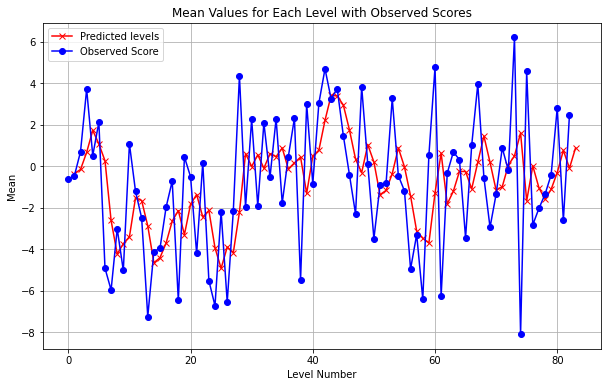

In [23]:
# Plot levels from training data against actual data

import re

# extract row names level 1 to level 80
pattern = re.compile(r'^level\[(\d+)\]$')
filtered_index = [item for item in trace_summary.index if pattern.match(item) and 0 <= int(pattern.match(item).group(1)) <= 100]

# Extract rows from the DataFrame with the filtered index
filtered_df = trace_summary.loc[filtered_index]

# create column level number
# Extract level numbers and add as a new column
filtered_df['level_number'] = filtered_df.index.to_series().str.extract(r'level\[(\d+)\]').astype(int)

# Sort the DataFrame by the level number
filtered_df = filtered_df.sort_values('level_number')

# Plot the means
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['level_number'], filtered_df['mean'], color='r', marker='x', label='Predicted levels')
plt.plot(observed_round_score,marker='o', color='b', label='Observed Score')
plt.xlabel('Level Number')
plt.ylabel('Mean')
plt.title('Mean Values for Each Level with Observed Scores')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# calculate future level for test set
n = len(observed_round_score)
print('n: ',n)
y_n = observed_round_score[n-1]
print('y_n: ',y_n)
alpha = trace_summary.loc['alpha']['mean']
print('alpha: ',alpha)
level_n = filtered_df.loc['level[83]']['mean']
print('level n: ',level_n)
future_level = (alpha*y_n) + (1 - alpha)*level_n
print('future level: ',future_level)

n:  83
y_n:  2.48
alpha:  0.18317825925755882
level n:  0.8823112195978363
future level:  1.1749730692272369


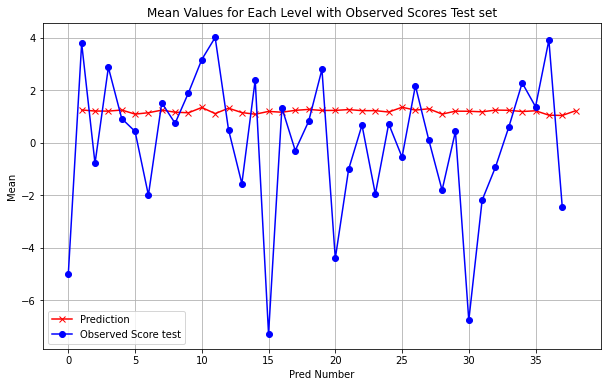

In [42]:
import re

# extract row names for y tilde - predictions
pattern = re.compile(r'^y_tilde\[(\d+)\]$')
tilde_index = [item for item in trace_summary.index if pattern.match(item) and 0 <= int(pattern.match(item).group(1)) <= 100]

# Extract rows from the DataFrame with the filtered index
filtered_df_tilde = trace_summary.loc[tilde_index]

filtered_df_tilde['pred_number'] = filtered_df_tilde.index.to_series().str.extract(r'y_tilde\[(\d+)\]').astype(int)

# Sort the DataFrame by the level number
filtered_df_tilde = filtered_df_tilde.sort_values('pred_number')

# Plot the means
plt.figure(figsize=(10, 6))
plt.plot(filtered_df_tilde['pred_number'], filtered_df_tilde['mean'], color='r', marker='x', label='Prediction')
plt.plot(observed_round_score_test,marker='o', color='b', label='Observed Score test')
plt.xlabel('Pred Number')
plt.ylabel('Mean')
plt.title('Mean Values for Each Level with Observed Scores Test set')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Section 4
# Get results

# Function to count how many times values in statistics[key][1] are greater than in statistics[key][0]
def count_greater_values(stats):
    counts = {}
    for key, (val0, val1) in stats.items():
        count = np.sum(val1 > val0)
        percentage = round(((count / len(val1)) * 100),2)
        ppp_value = count / len(val1)  # Posterior predictive p-value
        # Determine the alert level based on the PPP-value
        if ppp_value < 0.05 or ppp_value > 0.95:
            alert = "Red"
        elif 0.05 <= ppp_value < 0.1 or 0.9 < ppp_value <= 0.95:
            alert = "Amber"
        elif 0.45 <= ppp_value <= 0.55:
            alert = "Ideal"
        else:
            alert = "Acceptable"
        counts[key] = (count, percentage, alert)
    return counts


# Function to apply color coding
def color_code_alert(val):
    color = ''
    if val == "Ideal":
        color = 'lightgreen'
    elif val == "Acceptable":
        color = 'cyan'
    elif val == "Amber":
        color = 'orange'
    elif val == "Red":
        color = 'red'
    return f'background-color: {color}'



# Empty dictionary to store results
results = {}


# Section 4: Posterior Predictive P values
# Probability that the replicated data is more extreme than the actual data


# Will have 1k values for each value 
# E.g. Taking the min of the 80 observations 1k times
# This test is looking at all scores in set and taking 75% range - e.g. for 20 obs or 80 obs
# It is then comparing that to the 80 or 20 observations generated and that range
# Like for like test
statistics = {
        'min': (np.min(observed_round_score), np.min(y_sim, axis=1)),
        '2.5%': (np.percentile(observed_round_score,2.5),np.percentile(y_sim,2.5,axis=1)),
        '25%': (np.percentile(observed_round_score,25),np.percentile(y_sim,25,axis=1)),
        '50%': (np.percentile(observed_round_score,50),np.percentile(y_sim,50,axis=1)),
        'mean': (np.mean(observed_round_score), np.mean(y_sim, axis=1)),
        '75%': (np.percentile(observed_round_score,75),np.percentile(y_sim,75,axis=1)),
        '97.5%': (np.percentile(observed_round_score,97.5),np.percentile(y_sim,97.5,axis=1)),
        'max': (np.max(observed_round_score), np.max(y_sim, axis=1)),
        'std': (np.std(observed_round_score), np.std(y_sim, axis=1))
        }
    
statistics_test = {
        'min': (np.min(observed_round_score_test), np.min(y_tilde, axis=1)),
        '2.5%': (np.percentile(observed_round_score_test,2.5),np.percentile(y_tilde,2.5,axis=1)),
        '25%': (np.percentile(observed_round_score_test,25),np.percentile(y_tilde,25,axis=1)),
        '50%': (np.percentile(observed_round_score_test,50),np.percentile(y_tilde,50,axis=1)),
        'mean': (np.mean(observed_round_score_test), np.mean(y_tilde, axis=1)),
        '75%': (np.percentile(observed_round_score_test,75),np.percentile(y_tilde,75,axis=1)),
        '97.5%': (np.percentile(observed_round_score_test,97.5),np.percentile(y_tilde,97.5,axis=1)),
        'max': (np.max(observed_round_score_test), np.max(y_tilde, axis=1)),
        'std': (np.std(observed_round_score_test), np.std(y_tilde, axis=1))
        }
    
    
    # Find how many times the test statistic in simulated dataset exceeds actual data

# Get the counts
counts = count_greater_values(statistics)
    
# get the counts for the test set
counts_test = count_greater_values(statistics_test)

# Convert the counts dictionary to a DataFrame
df_counts = pd.DataFrame(counts).T.reset_index()
df_counts.columns = ['Statistic', 'Count', 'Percentage', 'Alert']
    
# Add Model column to df_counts
df_counts['Model'] = model_name
    
# Add split
df_counts['dataset'] = 'Train'
    
    
# Convert the counts dictionary to a DataFrame
df_counts_test = pd.DataFrame(counts_test).T.reset_index()
df_counts_test.columns = ['Statistic', 'Count', 'Percentage', 'Alert']
    
# Add Model column to df_counts
df_counts_test['Model'] = model_name
    
# Add split
df_counts_test['dataset'] = 'Test'
    
    
    
# Store results in dictionary
results[model_name] = {
        'count_rhat_greater_1_1': count_rhat_greater_1_1,
        'df_counts': df_counts,
        'df_counts_test': df_counts_test
    }


# Example: Print the summary statistics for each model
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Count of Rhat > 1.1: {result['count_rhat_greater_1_1']}")

    # Display styled dataframe
    df_counts_styled = result['df_counts'].style.applymap(color_code_alert, subset=['Alert'])
    df_counts_styled = df_counts_styled.format({'Percentage': '{:.2f}'})
    display(df_counts_styled)
    
    # Display styled dataframe for test set
    df_counts_styled_test = result['df_counts_test'].style.applymap(color_code_alert, subset=['Alert'])
    df_counts_styled_test = df_counts_styled_test.format({'Percentage': '{:.2f}'})
    display(df_counts_styled_test)
    
    




Model: Exponential Smoothing
Count of Rhat > 1.1: 0


,Statistic,Count,Percentage,Alert,Model,dataset
0,min,145,14.50,Acceptable,Exponential Smoothing,Train
1,2.5%,209,20.90,Acceptable,Exponential Smoothing,Train
2,25%,289,28.90,Acceptable,Exponential Smoothing,Train
3,50%,307,30.70,Acceptable,Exponential Smoothing,Train
4,mean,504,50.40,Ideal,Exponential Smoothing,Train
5,75%,722,72.20,Acceptable,Exponential Smoothing,Train
6,97.5%,852,85.20,Acceptable,Exponential Smoothing,Train
7,max,818,81.80,Acceptable,Exponential Smoothing,Train
8,std,817,81.70,Acceptable,Exponential Smoothing,Train


,Statistic,Count,Percentage,Alert,Model,dataset
0,min,921,92.10,Amber,Exponential Smoothing,Test
1,2.5%,967,96.70,Red,Exponential Smoothing,Test
2,25%,736,73.60,Acceptable,Exponential Smoothing,Test
3,50%,659,65.90,Acceptable,Exponential Smoothing,Test
4,mean,777,77.70,Acceptable,Exponential Smoothing,Test
5,75%,742,74.20,Acceptable,Exponential Smoothing,Test
6,97.5%,825,82.50,Acceptable,Exponential Smoothing,Test
7,max,903,90.30,Amber,Exponential Smoothing,Test
8,std,286,28.60,Acceptable,Exponential Smoothing,Test


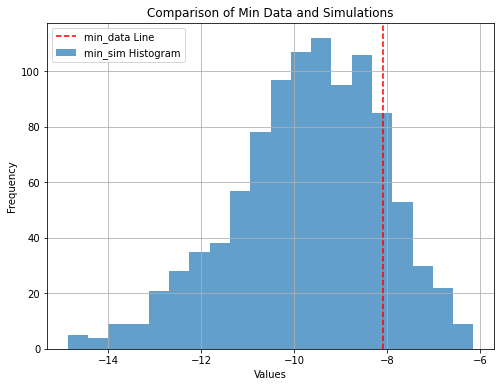

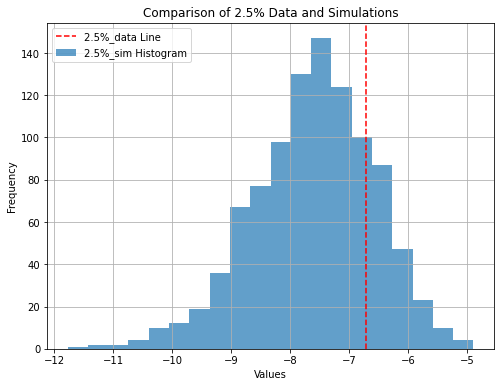

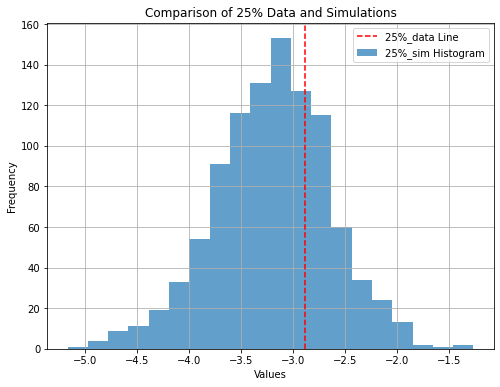

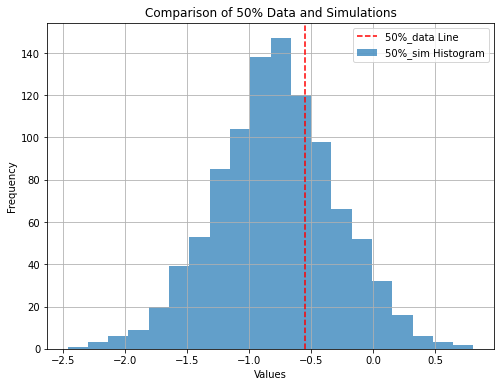

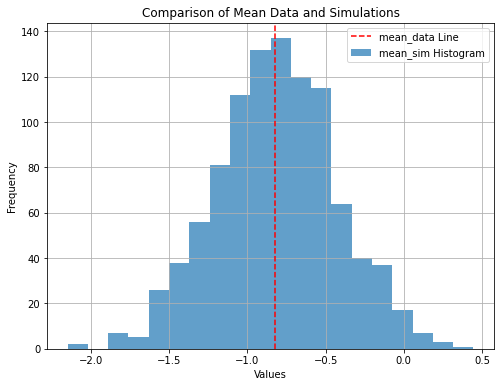

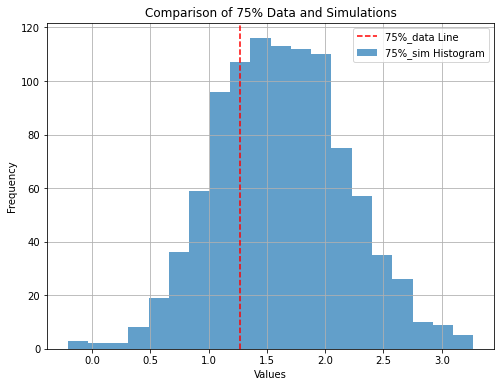

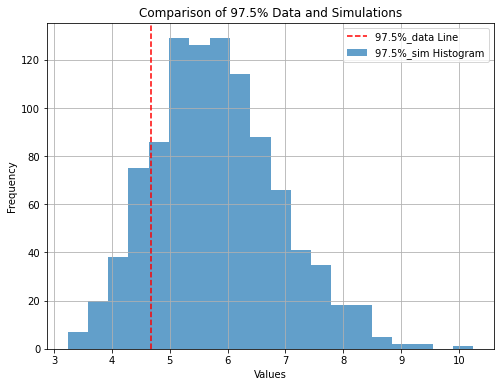

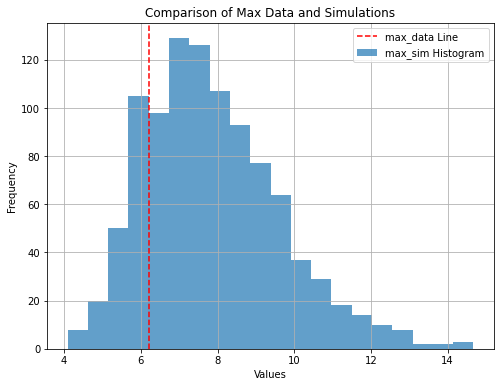

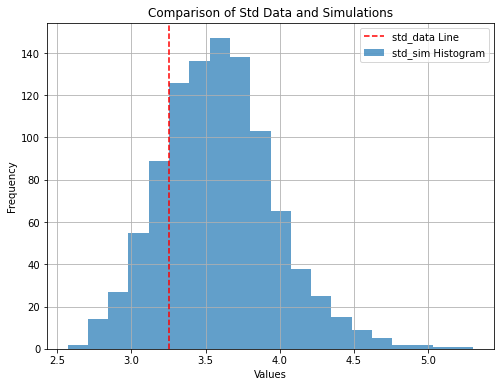

In [7]:
# Section 5: Plot Posterior Predictive Checks for training set
# Right now i'm taking the min of 80 observations and getting the min for each similated dataset


# Plot data
for stat_name, (data_value, sim_values) in statistics.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=20, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()


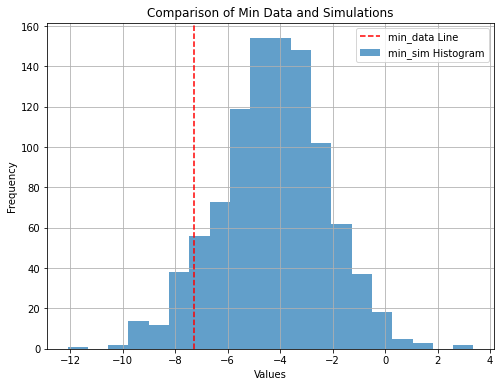

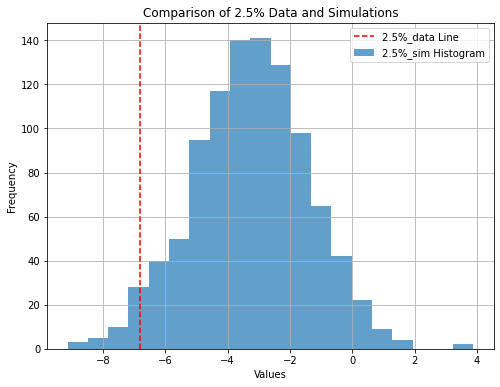

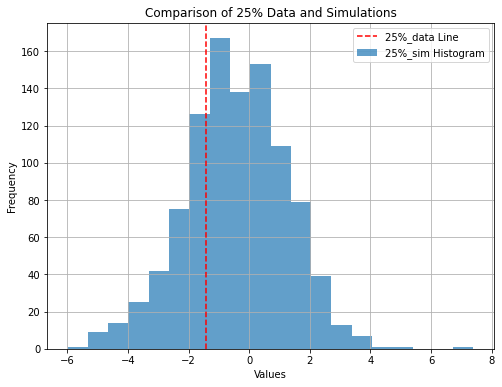

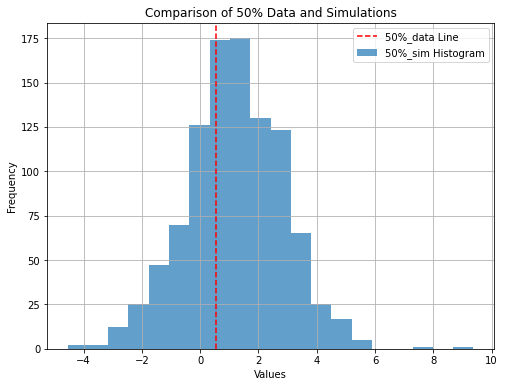

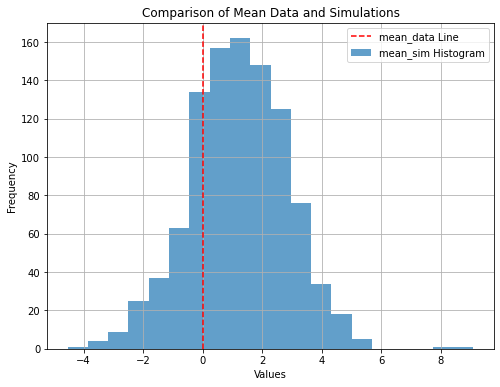

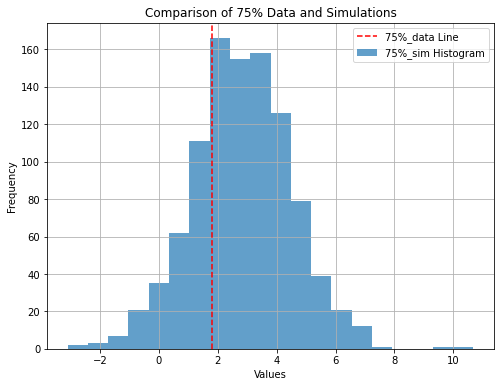

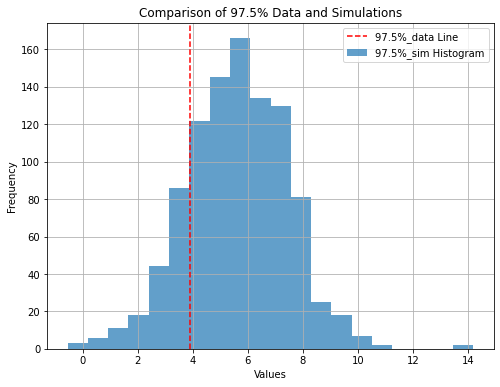

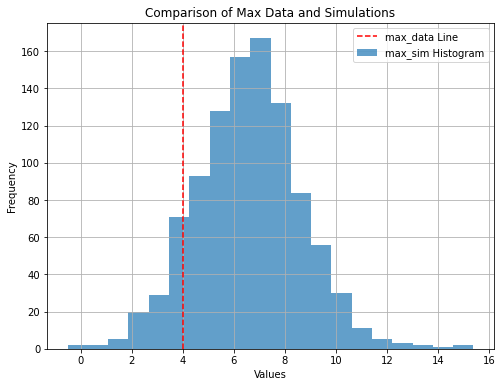

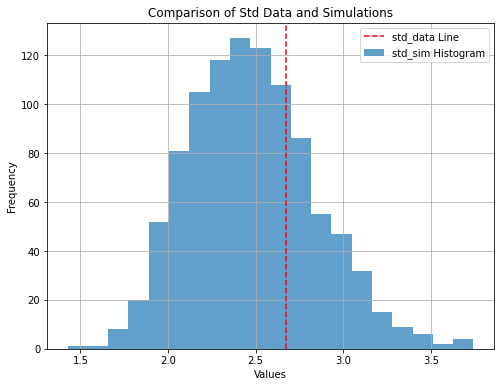

In [8]:
# Section 5: Plot Posterior Predictive Checks for test set
# Here I'm taking the min of 25 observations and plotting the values
# The 2.5% seems ok
# the 25, mean, median, 75 are off

# Plot data
for stat_name, (data_value, sim_values) in statistics_test.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=20, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()


training length:  83
   min_max  95_range  68_range  50_range
0      1.0  0.987952  0.915663  0.710843
Training RMSE: 2.01


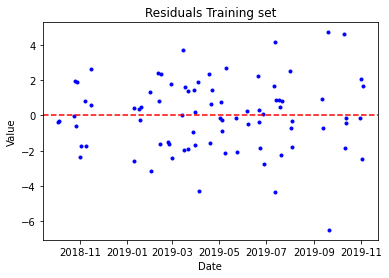

In [9]:
# For this test instead of range of 80 observations or 20 observations
# I'm getting the range of 1k data points
# So I have a predictive range for each of my observations
# Then want to see how many observations fall within ranges
# We would expect 95% of obs to fall within 95% ranges for each data point
# We would expect 50% to fall out of 50 range etc.
statistics_axis_0 = {
        'actual data': observed_round_score,
        'min':  np.min(y_sim, axis=0),
        '2.5%':  np.percentile(y_sim,2.5,axis=0),
        '16%': np.percentile(y_sim,16,axis=0),
        '25%': np.percentile(y_sim,25,axis=0),
        '50%': np.percentile(y_sim,50,axis=0),
        'mean':  np.mean(y_sim, axis=0),
        '75%':  np.percentile(y_sim,75,axis=0),
        '84%':  np.percentile(y_sim,84,axis=0),
        '97.5%': np.percentile(y_sim,97.5,axis=0),
        'max':  np.max(y_sim, axis=0)
        }

# get length of dataset
length_array = len(statistics_axis_0['actual data'])
print('training length: ',length_array)

count_within_min_max = 0  
count_within_95 = 0
count_within_68 = 0
count_within_50 = 0

for i in range(length_array):
    if statistics_axis_0['min'][i] <= statistics_axis_0['actual data'][i] <= statistics_axis_0['max'][i]:
        count_within_min_max += 1
    if statistics_axis_0['2.5%'][i] <= statistics_axis_0['actual data'][i] <= statistics_axis_0['97.5%'][i]:
        count_within_95 += 1
    if statistics_axis_0['25%'][i] <= statistics_axis_0['actual data'][i] <= statistics_axis_0['75%'][i]:
        count_within_50 += 1 
    if statistics_axis_0['16%'][i] <= statistics_axis_0['actual data'][i] <= statistics_axis_0['84%'][i]:
        count_within_68 += 1 
        

# Create a DataFrame with ranges for training set
training_set_ranges = pd.DataFrame({'min_max': [count_within_min_max/length_array],
                  '95_range': [count_within_95/length_array],
                  '68_range': [count_within_68/length_array],                
                  '50_range': [count_within_50/length_array]}
                 )

# Print the DataFrame
print(training_set_ranges)

# Calculate RMSE on Training dataset
# Take mean prediction and subtract actual data
rmse = np.sqrt(np.mean((statistics_axis_0['mean'] - statistics_axis_0['actual data']) ** 2))

# Print the RMSE
print(f'Training RMSE: {round(rmse,2)}')

# Plot Residuals over time for training set
# Seems to have fit the data well
plt.scatter(train_series.index, (statistics_axis_0['actual data'] - statistics_axis_0['mean']), label='Residuals', color='blue', marker='.')

# Add a red line at the 0 line
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Residuals Training set')
plt.show()


test length:  38
   min_max  95_range  68_range  50_range
0      1.0  0.921053  0.736842  0.605263
Test RMSE: 2.93


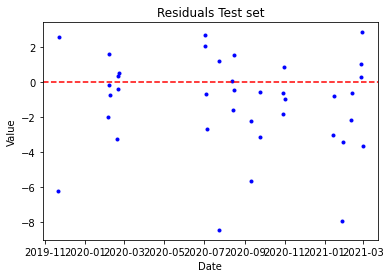

In [10]:
# Repeat exercise for test set

statistics_axis_0_test = {
        'actual data': observed_round_score_test,
        'min':  np.min(y_tilde, axis=0),
        '2.5%':  np.percentile(y_tilde,2.5,axis=0),
        '16%': np.percentile(y_tilde,16,axis=0),
        '25%': np.percentile(y_tilde,25,axis=0),
        '50%': np.percentile(y_tilde,50,axis=0),
        'mean':  np.mean(y_tilde, axis=0),
        '75%':  np.percentile(y_tilde,75,axis=0),
        '84%':  np.percentile(y_tilde,84,axis=0),
        '97.5%': np.percentile(y_tilde,97.5,axis=0),
        'max':  np.max(y_tilde, axis=0)
        }

# get length of dataset
length_array_test = len(statistics_axis_0_test['actual data'])
print('test length: ',length_array_test)

count_within_min_max_test = 0  
count_within_95_test = 0
count_within_50_test = 0
count_within_68_test = 0

for i in range(length_array_test):
    if statistics_axis_0_test['min'][i] <= statistics_axis_0_test['actual data'][i] <= statistics_axis_0_test['max'][i]:
        count_within_min_max_test += 1
    if statistics_axis_0_test['2.5%'][i] <= statistics_axis_0_test['actual data'][i] <= statistics_axis_0_test['97.5%'][i]:
        count_within_95_test += 1
    if statistics_axis_0_test['25%'][i] <= statistics_axis_0_test['actual data'][i] <= statistics_axis_0_test['75%'][i]:
        count_within_50_test += 1  
    if statistics_axis_0_test['16%'][i] <= statistics_axis_0_test['actual data'][i] <= statistics_axis_0_test['84%'][i]:
        count_within_68_test += 1  

# Create a DataFrame with ranges for training set
test_set_ranges = pd.DataFrame({'min_max': [count_within_min_max_test/length_array_test],
                  '95_range': [count_within_95_test/length_array_test],
                  '68_range': [count_within_68_test/length_array_test],             
                  '50_range': [count_within_50_test/length_array_test]}
                 )

# Print the DataFrame
# Sample set is very small 50 range looks off
# Only 43% of observations are between the 25% to 75% range
print(test_set_ranges)

# Calculate RMSE on Training dataset
# Take mean prediction and subtract actual data
rmse = np.sqrt(np.mean((statistics_axis_0_test['mean'] - statistics_axis_0_test['actual data']) ** 2))

# Print the RMSE
# The RMSE is actually better here than on the training set
# But pattern in residuals indicate time must be added to model
print(f'Test RMSE: {round(rmse,2)}')


# Plot Residuals over time for training set
# Seems to have fit the data well
plt.scatter(test_series.index, (statistics_axis_0_test['actual data'] - statistics_axis_0_test['mean']), label='Residuals', color='blue', marker='.')

# Add a red line at the 0 line
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Residuals Test set')
plt.show()

# 95 range looks fine
# Added more observations and ranges changed
# May need to add more data to fully test



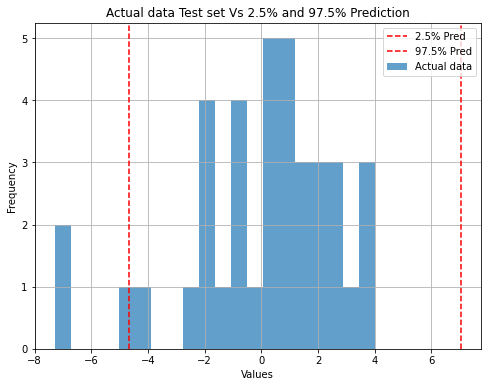

In [11]:
# Plot 95% range

plt.figure(figsize=(8, 6))
plt.axvline(x=statistics_axis_0_test['2.5%'].mean(), color='r', linestyle='--', label=f'2.5% Pred')
plt.axvline(x=statistics_axis_0_test['97.5%'].mean(), color='r', linestyle='--', label=f'97.5% Pred')
plt.hist(observed_round_score_test, bins=20, alpha=0.7, label=f'Actual data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Actual data Test set Vs 2.5% and 97.5% Prediction')
plt.legend()
plt.grid()

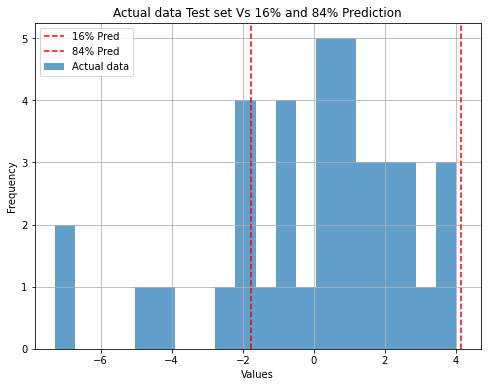

In [12]:
# Plot 68% Range
# Again its that one round that had 2 strokes gained thats causing problems
plt.figure(figsize=(8, 6))
plt.axvline(x=statistics_axis_0_test['16%'].mean(), color='r', linestyle='--', label=f'16% Pred')
plt.axvline(x=statistics_axis_0_test['84%'].mean(), color='r', linestyle='--', label=f'84% Pred')
plt.hist(observed_round_score_test, bins=20, alpha=0.7, label=f'Actual data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Actual data Test set Vs 16% and 84% Prediction')
plt.legend()
plt.grid()

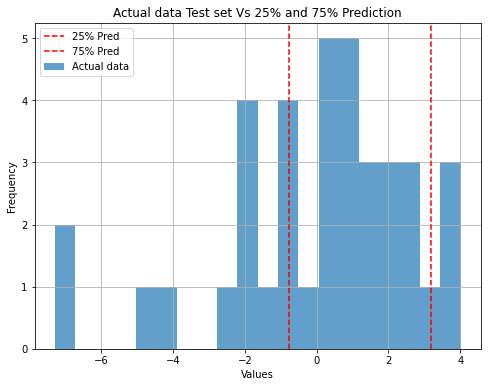

In [13]:
# Plot 50% Range
# Values are skewed with more good scores closer to 2
# There are 5 scores around 2-3
# his average was around -1 in the test set
# 2 of those scores were at the bermuda championship - an easy field
# 23 observations may be too small a training set


plt.figure(figsize=(8, 6))
plt.axvline(x=statistics_axis_0_test['25%'].mean(), color='r', linestyle='--', label=f'25% Pred')
plt.axvline(x=statistics_axis_0_test['75%'].mean(), color='r', linestyle='--', label=f'75% Pred')
plt.hist(observed_round_score_test, bins=20, alpha=0.7, label=f'Actual data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Actual data Test set Vs 25% and 75% Prediction')
plt.legend()
plt.grid()

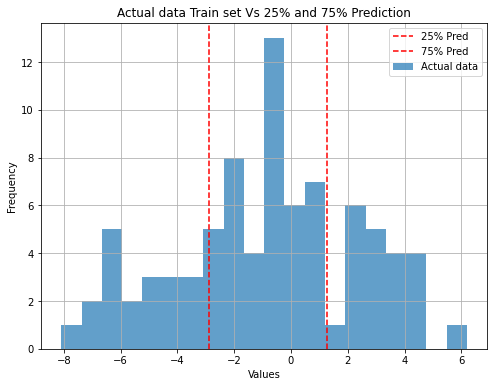

In [14]:
# Plot 50% range on training set
plt.figure(figsize=(8, 6))
plt.axvline(x=statistics_axis_0['25%'].mean(), color='r', linestyle='--', label=f'25% Pred')
plt.axvline(x=statistics_axis_0['75%'].mean(), color='r', linestyle='--', label=f'75% Pred')
plt.hist(observed_round_score, bins=20, alpha=0.7, label=f'Actual data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Actual data Train set Vs 25% and 75% Prediction')
plt.legend()
plt.grid()

In [21]:
# Find what are the other reasons he had so many scores more than 2 SG

# View data for Power

# Add prediction and residual columns
power_test['pred'] = np.round(statistics_axis_0_test['mean'],2)
power_test['resid'] = np.round((statistics_axis_0_test['actual data'] - statistics_axis_0_test['mean']),2)



# save csv
power_test[['player','n_rounds','made_cut','tournament name','course','purse','Finish',
       'Round_Score','Round_total','Avg_Score','Round_sg','pred','resid','date_round']].to_csv('power_test_ts.csv',index=False)
       
       
       

